In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/fumiya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
%matplotlib inline
import json
import time

from sklearn.model_selection import train_test_split
import spacy
from sklearn.metrics import accuracy_score
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
embeddings = nlp.vocab.vectors.data

from nltk.corpus import stopwords
from nltk import word_tokenize

STOPWORDS = set(stopwords.words('english'))

In [3]:
df = pd.read_json('Magazine.json', lines=True)
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


In [4]:
df['reviewText'] = df['summary'].map(str) + " " + df['reviewText'].map(str)
df = df.loc[:,['reviewText', 'overall']]
df.head()

,reviewText,overall
0,"AVID READER SINCE ""boot"" WAS THE NAME for com...",5
1,The straight scoop Thank god this is not a Zif...,5
2,"Antiques Magazine is Good, but not for Everyon...",3
3,THE DISCERNING READER This beautiful magazine...,5
4,Five Stars A great read every issue.,5


In [5]:
df = df.reset_index(drop=True)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['reviewText'] = df['reviewText'].astype('str').apply(clean_text)
df['reviewText'] = df['reviewText'].str.replace('\d+', '')

<ipython-input-5-fe16e0ab60a2>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df['reviewText'] = df['reviewText'].str.replace('\d+', '')


In [6]:
df.head()

,reviewText,overall
0,avid reader since boot name computer enthusias...,5
1,straight scoop thank god ziff davis publicatio...,5
2,antiques magazine good everyone antiques magaz...,3
3,discerning reader beautiful magazine work art ...,5
4,five stars great read every issue,5


In [7]:
df['overall'] = df['overall'].apply(lambda score: '1' if score > 3 else ('0' if score < 3 else '0'))

In [8]:
df.head()

,reviewText,overall
0,avid reader since boot name computer enthusias...,1
1,straight scoop thank god ziff davis publicatio...,1
2,antiques magazine good everyone antiques magaz...,0
3,discerning reader beautiful magazine work art ...,1
4,five stars great read every issue,1


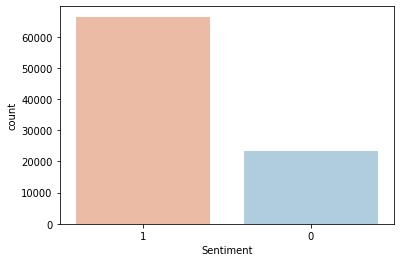

In [9]:
sns.countplot(x=df['overall'], data=df, palette='RdBu')
plt.xlabel('Sentiment')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

x = df['reviewText']
y = df['overall']

print(x.shape)
print(y.shape)

(89689,)
(89689,)


In [11]:
x_all, x = train_test_split(x, test_size=0.1, random_state=1234)
y_all, y = train_test_split(y, test_size=0.1, random_state=1234)

print(x.shape)
print(x.shape)
print(y.shape)
y.shape

(8969,)
(8969,)
(8969,)


(8969,)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1234)

In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
y_test.shape

(6726,)
(2243,)
(6726,)


(2243,)

## ロジスティック回帰

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


In [15]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train.values.astype('U'))
#transformed test reviews
cv_test_reviews=cv.transform(x_test.values.astype('U'))

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (6726, 245210)
BOW_cv_test: (2243, 245210)


In [16]:
lr=LogisticRegression(penalty='l2', max_iter=500)

In [18]:
lr = lr.fit(cv_train_reviews, y_train)

print(lr)

LogisticRegression(max_iter=500)


In [19]:
lr_predict = lr.predict(cv_test_reviews)

print(lr_predict)

['1' '1' '1' ... '1' '1' '1']


In [20]:
lr_score = accuracy_score(y_test, lr_predict)

print(lr_score)


0.7387427552385198


In [22]:
from sklearn.metrics import classification_report

target_names = ['４以上', '３以下']

print(classification_report(y_test, lr_predict,target_names=target_names))

              precision    recall  f1-score   support

         ４以上       1.00      0.00      0.00       587
         ３以下       0.74      1.00      0.85      1656

    accuracy                           0.74      2243
   macro avg       0.87      0.50      0.43      2243
weighted avg       0.81      0.74      0.63      2243



## ランダムフォレスト

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0)

rf.fit(cv_train_reviews, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [24]:
rf_predict = rf.predict(cv_test_reviews)


In [25]:
rf_score = accuracy_score(y_test, rf_predict)

print(rf_score)

0.7382969237628176


In [26]:
from sklearn.metrics import classification_report

target_names = ['４以上', '３以下']

print(classification_report(y_test, rf_predict,target_names=target_names))

              precision    recall  f1-score   support

         ４以上       0.00      0.00      0.00       587
         ３以下       0.74      1.00      0.85      1656

    accuracy                           0.74      2243
   macro avg       0.37      0.50      0.42      2243
weighted avg       0.55      0.74      0.63      2243

/home/fumiya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fumiya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fumiya/.local/lib/python3.8